# **Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs**

## Problem Tasks: 

- Assess if **weekly personal income** data has _direct and significant impacts_ on **public transport usage**. 

The dataset includes the total number of traveling methods of each personal income group in New South Wales taken from the **_TableBuilder of the Australian Bureau of Statistics (ABS)_**. 

**The census of Australian** was conducted in 2016, and the dataset was created and filtered from the census surveys of persons in usual residence areas across New South Wales, Australia. 

📊 **Process:**
- Data preparation: 

    - Data cleaning (transpose column to row, remove logo, title of organisation, etc.). 

    - Group the income into low income (class 0 - < 1000 AUD/week) and middle-high income (class 1 - > 1000 AUD/week).

- Data exploration: Plot graphs to compare transport usage in each income group to examine whether the transport usage would correlate with low or high income group.

- Model training: Logistic Regression, KNN, Gaussian Naive Bayes and MLPClassifier models.

🎯 **Goal:**

To study whether there is a correlation between transport mode usage and income of people - whether the group of income (of an employee) can be used to predict the preferred transport modes, and whether people with higher income prefer a certain mode of transport over others.

## Import Libraries

In [94]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# Functions used for linear regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics

# Functions used for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Import File and Create a Dataframe

As the dataset was taken from the TableBuilder of the ABS, we have to modify the Excel file which has been read in order to convert it into an "analysable" format of dataframe.

In [95]:
# Import data, skip the rows of logo and titles/names of the organisations
df = pd.read_excel("data/transportmodevsIncome.xlsx", skiprows= 8, index_col =0, engine="openpyxl")

# Set the first row as column names
df.columns = df.iloc[0]

# Remove the first two rows after setting it as column names (second row of NaN values and an header description)
df = df.iloc[2:]

# Remove several last rows of copyright, logo and sources
df = df[:5]

# Transpose columns and rows
df = df.T

# Remove several last rows of NaN values
income_tol = df[16:17] # the index "Total"
df_income = df[:16] # not include index "Total"

# Rename columns
income_tol.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]
df_income.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]

# Remove first row (transport title and NaN value)
df_income = df_income.iloc[1:]

# Final dataframe
df_income

,Train,Bus,Ferry,Tram,Total
INCP Total Personal Income: weekly (annually),,,,,
Negative income,350,147,22,10,530
Nil income,1070,547,27,7,1650
"$1-$149 ($1-$7,799)",6028,5454,53,54,11586
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,16526
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,20030
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,23755
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,32679
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,43265
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,55825


### Group Income Range into Class

In [96]:
# Add Class column to the dataframe
idx = 5
new_col = [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1]
df_income.insert(loc=idx, column="Class", value=new_col)
df_income

,Train,Bus,Ferry,Tram,Total,Class
INCP Total Personal Income: weekly (annually),,,,,,
Negative income,350,147,22,10,530,0
Nil income,1070,547,27,7,1650,0
"$1-$149 ($1-$7,799)",6028,5454,53,54,11586,0
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,16526,0
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,20030,0
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,23755,0
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,32679,0
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,43265,0
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,55825,0


### Data Summary

In [97]:
# DataFrame dimension
df_income.shape

(15, 6)

In [98]:
# Group by Class and sum transport mode columns
summary = df_income.groupby("Class")[["Train", "Bus", "Ferry", "Tram", "Total"]].sum()

# Display the summary
print(summary)  

        Train    Bus Ferry  Tram   Total
Class                                   
0      143102  60421  1306  1027  205846
1      231215  86021  8197  2334  327763


**Observations:**

1. **Class 1 (Higher income)** _uses public transport more_ than Class 0 (Lower income):

    - Total trips: 327,763 (Class 1) vs. 205,846 (Class 0)

    - Train is the most used mode for both classes.

2. **Higher income** = _more transport diversity_:

    - Class 1 shows higher use of bus, ferry, and tram, suggesting better access or broader commuting patterns.

3. Usage _peaks_ in **middle-to-upper income** ranges

    - Especially $800–$1,999/week groups → heavy users of all transport modes.

    - Very high incomes ($3,000+/week) show slight drop → possible shift to private transport.

## Data Exploration

Firstly, we plot a histogram of transport uses by each mode.

Text(0.5, 1.0, 'Total Usage by Transport Modes')

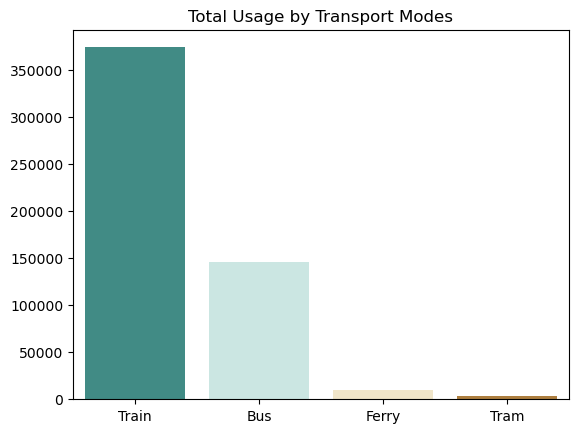

In [99]:
# Retrieve data for all transport modes and create plot
trans_modes_total = income_tol.drop(["Total"], axis=1)
sns.barplot(data= trans_modes_total, palette= "BrBG_r").set_title("Total Usage by Transport Modes")

* ***Interpretation:*** Train service has the largest number of passengers across all income groups (> 350.000 in total)

And another plot to find out how income range _uses all the transport modes_:

In [100]:
# Retrieve data for all transport modes by age groups
trans_modes_by_incgr = df_income.drop(["Class", "Total"], axis=1)
trans_modes_by_incgr["Income Range"] = trans_modes_by_incgr.index
trans_modes_by_incgr

,Train,Bus,Ferry,Tram,Income Range
INCP Total Personal Income: weekly (annually),,,,,
Negative income,350,147,22,10,Negative income
Nil income,1070,547,27,7,Nil income
"$1-$149 ($1-$7,799)",6028,5454,53,54,"$1-$149 ($1-$7,799)"
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,"$150-$299 ($7,800-$15,599)"
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,"$300-$399 ($15,600-$20,799)"
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,"$400-$499 ($20,800-$25,999)"
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,"$500-$649 ($26,000-$33,799)"
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,"$650-$799 ($33,800-$41,599)"
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,"$800-$999 ($41,600-$51,999)"


In [101]:
# Unpivot the data by transport types
trans_modes_by_incgr_melted = pd.melt(trans_modes_by_incgr, id_vars = "Income Range", var_name="Transport Types")

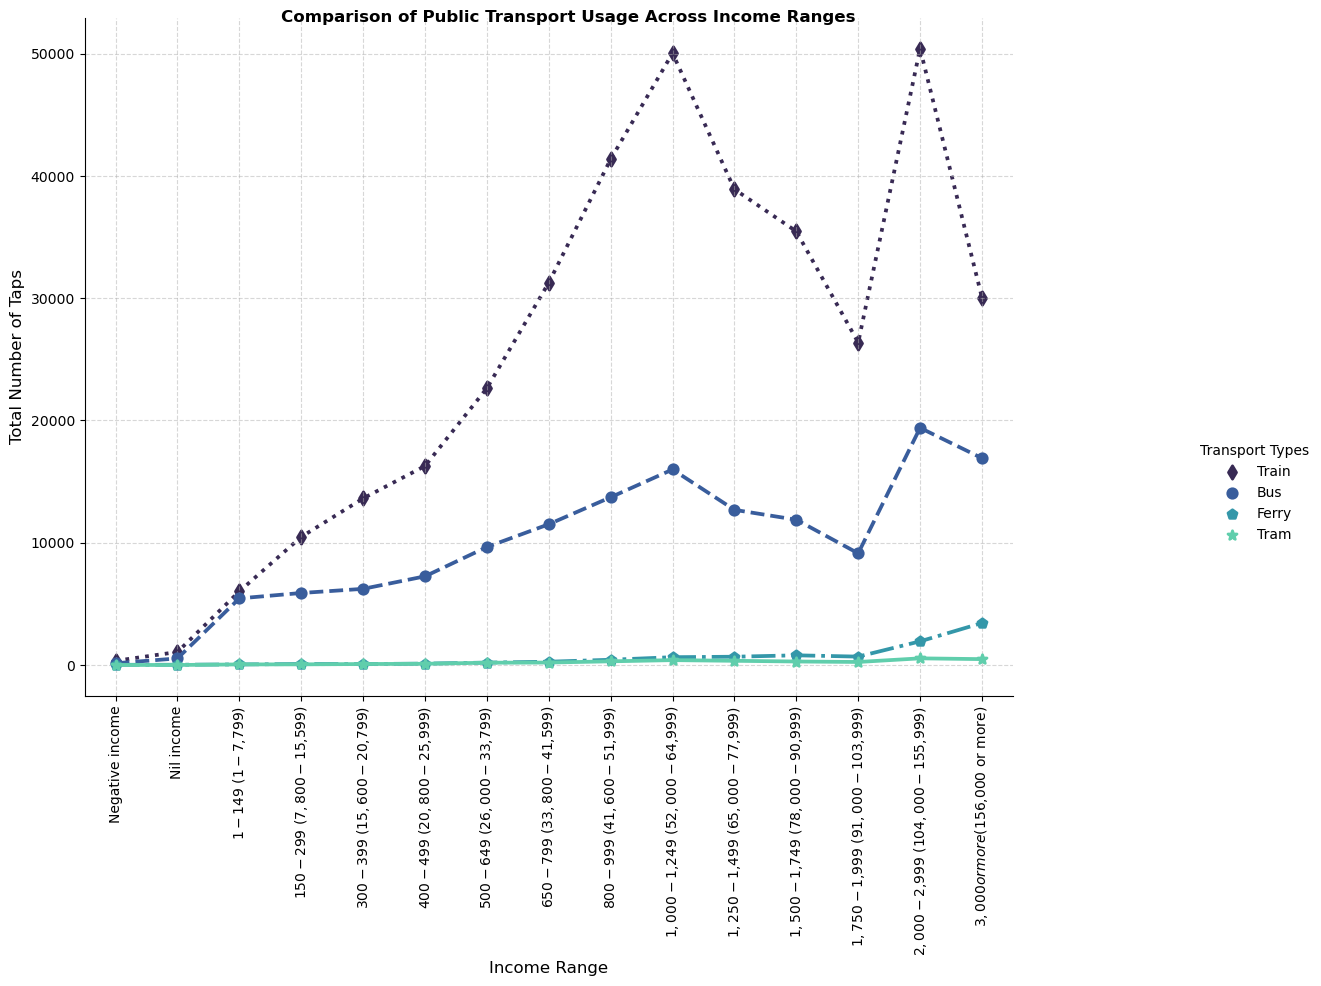

In [102]:
# Create the plot
trans_modes_by_incgr_plot = sns.catplot(
    x="Income Range", y="value",
    markers=["d", "o", "p", "*"], 
    linestyles=["dotted", "dashed", "dashdot", "solid"],
    kind="point", hue="Transport Types",
    data=trans_modes_by_incgr_melted, palette="mako"
)

# Adjust figure size
trans_modes_by_incgr_plot.fig.set_size_inches(15,8)

# Set title with better font size
trans_modes_by_incgr_plot.fig.suptitle(
    "Comparison of Public Transport Usage Across Income Ranges", 
    fontsize=12, fontweight="bold"
)

# Set axis labels
plt.xlabel("Income Range", fontsize=12)
plt.ylabel("Total Number of Taps", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add gridlines for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

**Key Insights:**

1. **Middle-income groups ($800–$2,999)** are the _heaviest public transport users_.

2. **Train** 🚆 is the _preferred mode_, while **bus** 🚍 serves as a _secondary option_.

3. **Ferry & tram** 🚋⛴️ are niche transport modes, _mostly used by higher-income groups_.

4. **High-income individuals ($3,000+)** 💸 may shift towards _private vehicles_.

Analyzing the usage of each transport mode by each age range in percentage will provide a proper assessment on **how all transport modes are distributed**.

In [103]:
# Transform the data to percentage
transport_modes = ["Train", "Bus", "Ferry", "Tram"]
df_income_copy = df_income.copy()
df_income_copy[transport_modes] = df_income_copy[transport_modes].div(df_income_copy["Total"], axis=0) * 100
df_income_copy.fillna(0, inplace=True)  # Replace NaN values if any division by zero occurred
# View the updated dataframe
df_income_copy

,Train,Bus,Ferry,Tram,Total,Class
INCP Total Personal Income: weekly (annually),,,,,,
Negative income,66.037736,27.735849,4.150943,1.886792,530,0
Nil income,64.848485,33.151515,1.636364,0.424242,1650,0
"$1-$149 ($1-$7,799)",52.02831,47.074055,0.457449,0.46608,11586,0
"$150-$299 ($7,800-$15,599)",63.421276,35.665013,0.526443,0.357013,16526,0
"$300-$399 ($15,600-$20,799)",68.042936,31.118323,0.419371,0.424363,20030,0
"$400-$499 ($20,800-$25,999)",68.528731,30.549358,0.509366,0.446222,23755,0
"$500-$649 ($26,000-$33,799)",69.279966,29.535788,0.618134,0.593653,32679,0
"$650-$799 ($33,800-$41,599)",72.266266,26.615047,0.635618,0.476135,43265,0
"$800-$999 ($41,600-$51,999)",74.086879,24.580385,0.779221,0.548142,55825,0


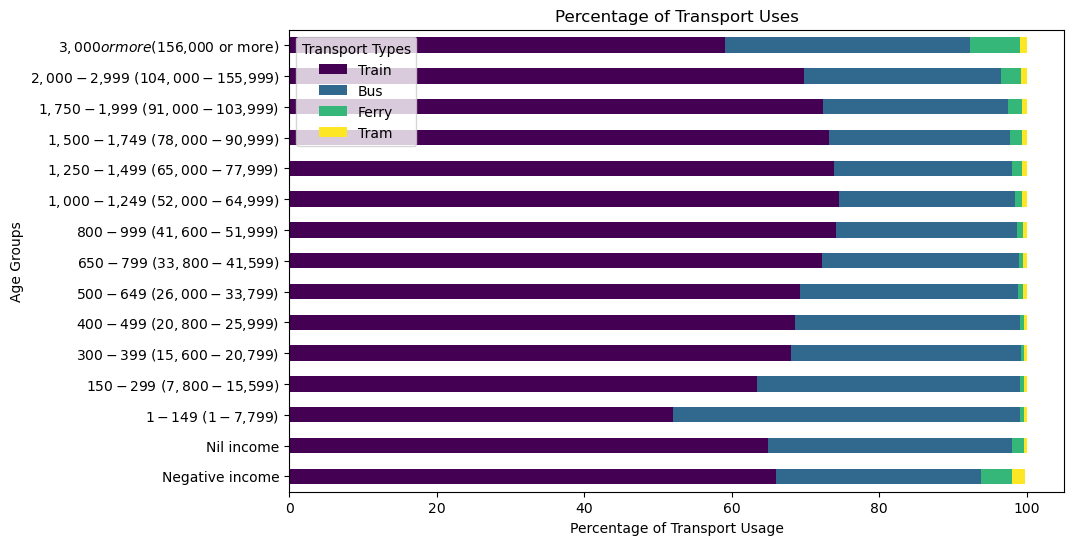

In [104]:
# Plot how all transport modes are distributed in each age range
trans_modes_by_incgr_perc = df_income_copy[["Train", "Bus", "Ferry", "Tram"]].copy()
trans_modes_by_incgr_perc["Age Groups"] = df_income_copy.index

trans_modes_by_incgr_perc_plot = trans_modes_by_incgr_perc.plot(
    x="Age Groups", kind="barh", stacked=True, 
    title="Percentage of Transport Uses", colormap="viridis", figsize=(10, 6)
)
trans_modes_by_incgr_perc_plot.set_xlabel("Percentage of Transport Usage")
trans_modes_by_incgr_perc_plot.set_ylabel("Age Groups")
trans_modes_by_incgr_perc_plot.legend(title="Transport Types")

**Key Insights:**
1. **Train** is still the _preferred mode across all income levels_, especially for **_middle-to-high earners_**.

2. **Bus** is _critical for_ **low-income groups** but declines as income increases.

3. **Ferry and tram** are niche transport options, mainly for higher earners.

These insights on each transport mode are all reinforced again with this plot.

Lastly, we examine how **the number of travellings of each income range class varies**. (Note: _we have defined two classes_).

<AxesSubplot: title={'center': 'Transport Usage by Income Range Class'}, xlabel='Class', ylabel='Total'>

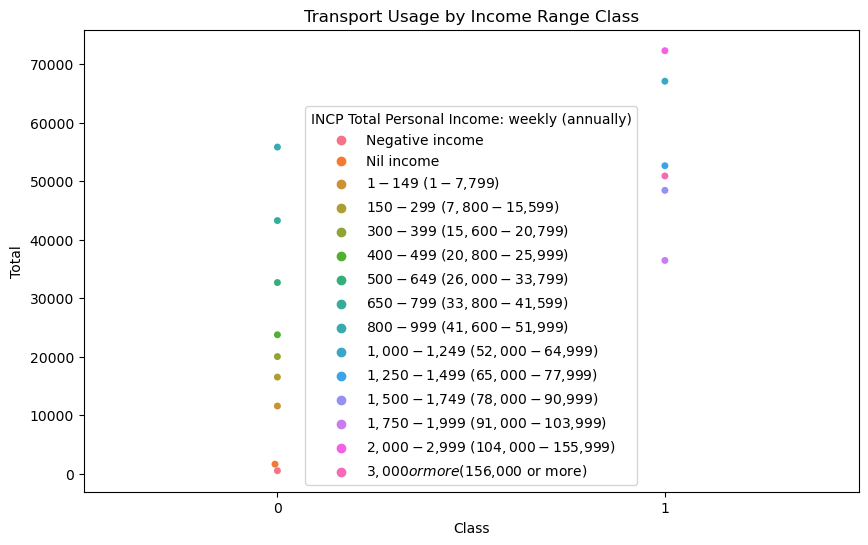

In [105]:
# Plot transport usage by each income range class
plt.figure(figsize=(10,6))
plt.title("Transport Usage by Income Range Class")
sns.swarmplot(x='Class', y='Total', data= df_income, hue= df_income.index)

**Key Insights:** 

- The **Class 1** group has **_higher total transport usage_** (up to **70,000**) → higher-income individuals _tend to use public transport more overall_.

- The **Class 0** group shows **_lower transport usage_**, with totals clustering below **50,000** → lower-income individuals have _fewer travel needs or rely on alternative transport modes_.

## Model Training

There are two classes: 
- Class 0: low-income earners

- Class 1: higher-income earner

### Splitting Data

In [106]:
# Split data into training and testing sets (50% each)
train, test = train_test_split(df_income, test_size=0.5, random_state=7)

# Separate features and target
X_train, X_test = train.drop(columns=['Total', 'Class']), test.drop(columns=['Total', 'Class'])
y_train, y_test = train['Class'], test['Class']

# Print shapes for verification
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Train shape: (7, 6), Test shape: (8, 6)
X_train: (7, 4), y_train: (7,)
X_test: (8, 4), y_test: (8,)


In [107]:
X_train.head()

,Train,Bus,Ferry,Tram
INCP Total Personal Income: weekly (annually),,,,
"$2,000-$2,999 ($104,000-$155,999)",50401,19397,1940,550
"$650-$799 ($33,800-$41,599)",31266,11515,275,206
"$1,500-$1,749 ($78,000-$90,999)",35459,11883,798,292
"$150-$299 ($7,800-$15,599)",10481,5894,87,59
"$500-$649 ($26,000-$33,799)",22640,9652,202,194


### Logistic Regression

**Fitting the model:**

In [108]:
# Create model instance and fit the training data 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [109]:
# Produce predictions with LR model
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [110]:
# Evaluate LR model
print(f"Accuracy Score on training test: {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test, y_test_pred)}")

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.75


The model has a **perfect accuracy (1.0)** on the training set but a **lower accuracy (0.625)** on the test set, which suggests **_overfitting_**.

In [111]:
# List of accuracy scores on test set
test_scores = []
test_scores.append(accuracy_score(y_test, y_test_pred))

**Confusion matrix:**

In [112]:
# Confusion matrix on test set
print("Confusion matrix on test set:")
print(confusion_matrix(y_test, y_test_pred))

Confusion matrix on test set:
[[3 2]
 [0 3]]


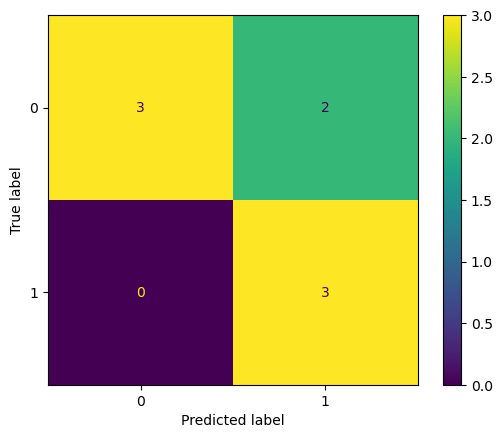

In [113]:
# Display confusion matrix of Logistic Regression model
plot_confusion_matrix(lr, X_test, y_test)

- 2 false predictions of **class 1 (high income)** while they are actually **class 0 (low income)** → this model might predict incorrectly the low income group based on the number of transport uses.

In [114]:
# Define list to store accuracy scores
acc_scores = []

for i in range(1,5):
    # Create model instance 
    lr = LogisticRegression(max_iter=1000)

    # Create RFE model
    rfe = RFE(estimator=lr, n_features_to_select=i)

    # Fit the RFE model
    rfe.fit(X_train, y_train)

    # Prodce predictions with RFE model
    y_pred = rfe.predict(X_test)

    # Evaluate RFE model
    acc_score = accuracy_score(y_test, y_pred)

    # Print the accuracy score with the number of features
    print ("Acc on test set using", i, "feature: ", acc_score)
    print ("Feature which have been chosen:", X_train.columns[rfe.support_])
    print("")

    # Append to the list 
    acc_scores.append(acc_score)

Acc on test set using 1 feature:  1.0
Feature which have been chosen: Index(['Ferry'], dtype='object')

Acc on test set using 2 feature:  1.0
Feature which have been chosen: Index(['Ferry', 'Tram'], dtype='object')

Acc on test set using 3 feature:  0.75
Feature which have been chosen: Index(['Bus', 'Ferry', 'Tram'], dtype='object')

Acc on test set using 4 feature:  0.75
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry', 'Tram'], dtype='object')



### RFE

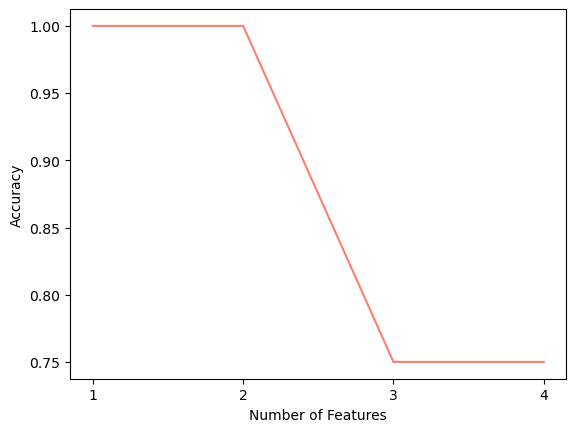

In [115]:
# Plotting the accuracy scores with the number of features
rfe_scores = plt.plot(range(1, X_train.shape[1]+1), acc_scores, color= "salmon")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, 5 , step=1))
plt.show()

*  Though 2 features (**ferry and tram**) produce _100% precise income group prediction_, training a model of all **4 features** still provides _a decent performance (0.75)_ while avoiding **_overfitting_** issue.

**Cross-Validation Testing:**

In [116]:
# Retrieve data for the cross-validation test on LR model
X = df_income.drop(["Total", "Class"], axis= 1)
y = df_income["Class"]

In [117]:
# Create LR model instance
lr = LogisticRegression(max_iter=1000)

# Generate cross-validation scores
lr_cv_score = cross_val_score(lr, X, y, scoring='accuracy', cv=5)

# Print the accuracy range, mean and standard deviation
print('Accuracy range for Logistic Regression: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (lr_cv_score.min(), lr_cv_score.max(), lr_cv_score.mean(), lr_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(lr_cv_score.mean())

Accuracy range for Logistic Regression: [0.3333, 1.0000]; mean: 0.8000; std: 0.2667



The model shows **decent accuracy** but **_high variance_**:

- The accuracy varies significantly from **0.3333 to 1.0000** across different CV folds → **inconsistency** in model performance due to **_data imbalance_**.

- A fairly decent **average accuracy of 0.8000 (80%)** → not **fully reliable** given the **_large variance_**.

- A **std of 0.2667** is quite high → the model’s performance is **_unstable across different data splits_**.

### K-Nearest Neighbours Classifier

**Fitting the model:**

In [118]:
# Create a K-Nearest Neighbours Classifier model instance and fit the training data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [119]:
# Produce predictions with KNN model
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [120]:
# Evaluate KNN model
print(f"Accuracy Score on training test: {round(accuracy_score(y_train, y_train_pred), 2)}")
print(f"Accuracy Score on testing test: {round(accuracy_score(y_test, y_test_pred), 2)}")

# Append the accuracy score to the list
test_scores.append(accuracy_score(y_test, y_test_pred))

Accuracy Score on training test: 0.86
Accuracy Score on testing test: 0.62


The **KNN model** 

- **Training accuracy: 86%** → Learn the patterns in the dataset well.

- **Testing accuracy: 62%** → Possible **_overfitting_**

**Key Insights:**

- Increasing k _reduced overfitting_, but _training accuracy dropped significantly_.

- Testing accuracy remains unchanged, suggesting **_model limitations or irrelevant features_**.

<b> Cross-Validation Testing:

In [121]:
# Create a K-Nearest Neighbours Classifier model instance
knn = KNeighborsClassifier(n_neighbors=3)

# Generate cross-validation scores for KNN model with cross-validation
knn_cv_score = cross_val_score(knn, X, y, scoring='accuracy', cv=2)

# Print the accuracy range, mean and standard deviation
print('Accuracy range for K-Nearest Neighbours: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (knn_cv_score.min(), knn_cv_score.max(), knn_cv_score.mean(), knn_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(knn_cv_score.mean())

Accuracy range for K-Nearest Neighbours: [0.6250, 0.7143]; mean: 0.6696; std: 0.0446



The model achieves **averagely good accuracy** and **moderate variability**:

- **Decent Performance**: The model achieves a reasonable mean accuracy (**66.96%**).

- **Low Variance**: The small standard deviation suggests stable performance across folds (**4.46%**).

### Gaussian Naive Bayes

**Fitting the model:**

In [122]:
# Create a Gaussian Naive Bayes model instance and fit the training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [123]:
# Produce predictions with GNB model
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

In [124]:
# Evaluate GNB model
print(f"Accuracy Score on training test: {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test, y_test_pred)}")

# Append the accuracy score to the list
test_scores.append(accuracy_score(y_test, y_test_pred))

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.875


- **Training Accuracy: 100%** (Possible overfitting ⚠️) → 100% training accuracy suggests the model may be memorizing training data rather than generalizing well.

- **Testing Accuracy: 87.5%** (Good generalization).

<b>Cross-Validation Testing:

In [125]:
# Create a Gaussian Naive Bayes model instance
gnb = GaussianNB()

# Generate cross-validation scores for GNB model with cross-validation
gnb_cv_score = cross_val_score(gnb, X, y, scoring='accuracy', cv=5)

# Print the accuracy range, mean and standard deviation for GNB model   
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (gnb_cv_score.min(), gnb_cv_score.max(), gnb_cv_score.mean(), gnb_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(gnb_cv_score.mean())

Accuracy range for Gaussian Naive Bayes: [0.3333, 1.0000]; mean: 0.8667; std: 0.2667



- **Good Mean Accuracy**: **86.67%** suggests overall good performance.

- **High Variance**: A wide accuracy range (**33.33% to 100%**) indicates inconsistency across folds → Possible causes can be **_imbalanced class data_** and **_limited dataset size_**.

### Multi-layer Perceptron

**Fitting the model:**

In [126]:
# Create a Multi-layer Perception model instance and fit the training data
mlp = MLPClassifier(max_iter=800, solver="lbfgs", activation="tanh", random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(activation='tanh', max_iter=800, random_state=42, solver='lbfgs')

In [127]:
# Produce predictions with MLP model
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

In [128]:
# Evaluate MLP model 
print(f"Accuracy Score on training test: {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test, y_test_pred)}")

# Append the accuracy score to the list
test_scores.append(accuracy_score(y_test, y_test_pred))

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.75


The possibility of **_overfitting_** still exists when **testing accuracy (60%)** is moderate, but there's a big gap from **training accuracy (100%)**.

**Cross-Validation Testing:**

In [129]:
# Create a Multi-layer Perception model instance
mlp =  MLPClassifier(max_iter=800, solver="lbfgs", activation="tanh", random_state=42)

# Generate cross-validation scores for MLP model with cross-validation
mlp_cv_score = cross_val_score(mlp, X, y, scoring='accuracy', cv=5)

# Print the accuracy range, mean and standard deviation for MLP model
print('Accuracy range for MLP: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (mlp_cv_score.min(), mlp_cv_score.max(), mlp_cv_score.mean(), mlp_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(mlp_cv_score.mean())

Accuracy range for MLP: [0.0000, 1.0000]; mean: 0.6000; std: 0.3266



The model shows **unstable performance** by _extreme accuracy range of **0% to 100%**_ across folds and **very high variance (std = 32.66%)**.

### Model Comparison

In [132]:
# Create a dataframe to store the accuracy scores
models = ["LR_Split", "LR_CV", "KNN_Split", "KNN_CV", "GNB_Split", "GNB_CV", "MLP_Split", "MLP_CV"]
df_acc_score = pd.DataFrame(models, columns=["Model Type"])
df_acc_score["Accuracy"] = test_scores

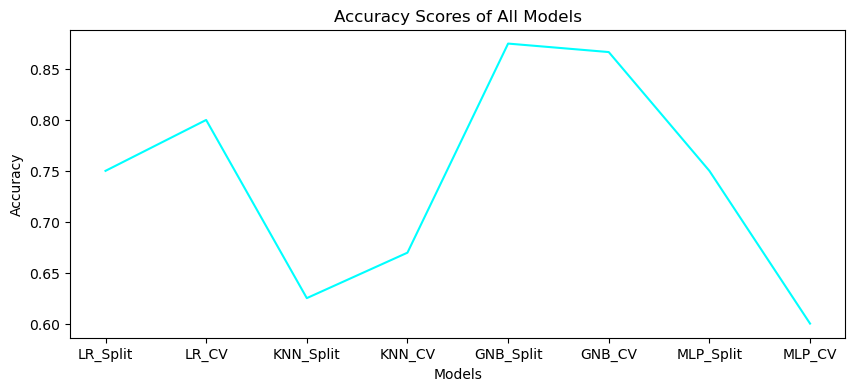

In [133]:
# Plot the accuracy scores of all models 
plt.figure(figsize = (10,4))
plt.plot(df_acc_score["Model Type"], df_acc_score["Accuracy"], color= "aqua")
plt.title("Accuracy Scores of All Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

The plot shows **accuracy scores** for different models using both **_train-test split (Split)_** and **_cross-validation (CV)_** approaches:

- `GNB_CV` & `GNB_Split` perform the best (**~0.87–0.90 accuracy**).

- **KNN models** (`KNN_Split` & `KNN_CV`) have **_poor performance_** compared to others.

- `MLP_CV` (**Multi-Layer Perceptron with CV**) is **_the worst performer_**.

    → The most optimal model is `GNB_Split` (**Gaussian Naive Bayes - Split Validation**) due to the _highest accuracy_ with _lower variance_ compared to other models.

## Conclusion

The `transport usage by income range` dataset was handled carefully before data exploration and model training tasks: 
- Remove logos and titles. 

- Remove outliers due to 2 groups with zero-records.

- Recalculate the total field to minimise the incorrect data. 

The most _noticeable observation_ on this dataset is still the **small dimensionality**, thus it directly leads to the **overfitting** and **high variance** issues.

A combination of **4 models** have been trained on the dataset and they show different key insights. Despite _various disadvantages due to small dataset size_, **Gaussian Naive Bayes - Split Validation** is recognized as the most best model.